# 1 .구글 드라이브와 연결

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# 마운트된 드라이브 경로 확인
import os
project_path = '/content/gdrive/My Drive/sw융합프로젝트(1)/'

# 해당 폴더 내 파일 목록 확인
files = os.listdir(project_path)
print(files)

['행정구역(읍면동)', '행정구역(시군구)', '인천광역시_시내버스 정류소 현황_20241231.csv', '인천광역시.geojson', '아파트(매매)_실거래가_20250512141056.csv', '연립다세대(전월세)_실거래가_20250512142423.csv', '아파트(전월세)_실거래가_20250512142547.csv', '연립다세대(매매)_실거래가_20250512142554.csv', 'multi_geocoded.csv', 'apt_geocoded.csv']


# 2. 인천 서구 정류소 현황

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium

In [4]:
import pandas as pd

# 파일 경로 설정
csv_path = '/content/gdrive/My Drive/sw융합프로젝트(1)/인천광역시_시내버스 정류소 현황_20241231.csv'

# 1. CSV 불러오기
bus_seogu_df = pd.read_csv(csv_path, encoding='utf-8')  # 한글깨짐 방지
bus_seogu_df.head()

# 위도 경도가 반대로 되어 있음

,기준 일자,정류소 명,정류소 번호,정류소아이디,권역,행정동 명,엑스좌표,위도,와이좌표,경도
0,2024-12-31,(구)주안2동치안센터,37302.0,163000302,미추홀구,주안2동,170842.1600,126.671236,439486.1420,37.457078
1,2024-12-31,(주)경동세라믹스,89146.0,168001146,서구,오류왕길동,166087.8384,126.616978,450837.1724,37.559186
2,2024-12-31,(주)경인양행앞,42096.0,168000096,서구,가좌1동,170343.6370,126.665414,444145.8737,37.499045
3,2024-12-31,(주)경인양행앞,42097.0,168000097,서구,석남2동,170465.3876,126.666789,444178.4131,37.499342
4,2024-12-31,(주)대한특수금속,39050.0,165000050,남동구,논현고잔동,172879.0446,126.694491,433147.5666,37.400029


In [5]:
# 위도랑 경도 제대로 고치기 (원본 데이터가 이상함)
bus_seogu_df = bus_seogu_df.rename(columns={'위도': '경도_tmp', '경도': '위도'})
bus_seogu_df = bus_seogu_df.rename(columns={'경도_tmp': '경도'})
bus_seogu_df

,기준 일자,정류소 명,정류소 번호,정류소아이디,권역,행정동 명,엑스좌표,경도,와이좌표,위도
0,2024-12-31,(구)주안2동치안센터,37302.0,163000302,미추홀구,주안2동,170842.1600,126.671236,439486.1420,37.457078
1,2024-12-31,(주)경동세라믹스,89146.0,168001146,서구,오류왕길동,166087.8384,126.616978,450837.1724,37.559186
2,2024-12-31,(주)경인양행앞,42096.0,168000096,서구,가좌1동,170343.6370,126.665414,444145.8737,37.499045
3,2024-12-31,(주)경인양행앞,42097.0,168000097,서구,석남2동,170465.3876,126.666789,444178.4131,37.499342
4,2024-12-31,(주)대한특수금속,39050.0,165000050,남동구,논현고잔동,172879.0446,126.694491,433147.5666,37.400029
...,...,...,...,...,...,...,...,...,...,...
6915,2024-12-31,힐스테이트학익104동앞,37669.0,163000669,미추홀구,용현5동,168741.3734,126.647550,438140.7792,37.444887
6916,2024-12-31,힐캐슬프라자,39331.0,165000331,남동구,구월2동,174638.7810,126.714149,439413.5819,37.456536
6917,2024-12-31,힐캐슬프라자,39329.0,165000329,남동구,구월2동,174634.8498,126.714105,439385.9196,37.456287
6918,2024-12-31,힘찬병원,40892.0,166000892,부평구,부평5동,176029.5694,126.729737,443418.2177,37.492655


In [6]:
# 1. 원본에서 복사본 생성 (명시적 copy)
bus_seogu_df = bus_seogu_df.copy()

# 2. 권역 컬럼 공백 제거
bus_seogu_df['권역'] = bus_seogu_df['권역'].str.strip()

# 3. 서구만 필터링
bus_seogu_df = bus_seogu_df[bus_seogu_df['권역'] == '서구'].copy()

# 4. geometry 생성 (Point(경도, 위도))
bus_seogu_df['geometry'] = bus_seogu_df.apply(lambda row: Point(row['위도'], row['경도']), axis=1)

# 5. GeoDataFrame 생성
gdf_seogu_bus = gpd.GeoDataFrame(bus_seogu_df, geometry='geometry', crs='EPSG:4326')

### 정류소 위치 찍어보기

In [7]:
center_lat = gdf_seogu_bus['위도'].mean()
center_lon = gdf_seogu_bus['경도'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

for _, row in gdf_seogu_bus.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.7,
        popup=row['정류소 명']
    ).add_to(m)

m

# 3. 행정동 경계 불러오기

In [8]:
import geopandas as gpd

# Shapefile 경로
shp_path = '/content/gdrive/My Drive/sw융합프로젝트(1)/행정구역(읍면동)/N3A_G0110000.shp'

# GeoDataFrame으로 읽기
gdf_legal_dong = gpd.read_file(shp_path)

# 컬럼 확인
print(gdf_legal_dong.columns)
gdf_legal_dong.head() # 행정동이 아니라 법정동으로 되어 있음

Index(['UFID', 'BJCD', 'NAME', 'DIVI', 'SCLS', 'FMTA', 'geometry'], dtype='object')


,UFID,BJCD,NAME,DIVI,SCLS,FMTA,geometry
0,100036706058G01110100000000000000,4311311300,가경동,HJD010,G0018117,S2114221,"POLYGON ((239021.232 448347.246, 239031.621 44..."
1,100034702010G01110100000000000001,4615010900,가곡동,HJD010,G0018117,S2117450,"POLYGON ((244735.267 265181.504, 244707.779 26..."
2,100034702010G01110100000000000002,4827010800,가곡동,HJD010,G0018117,S2117450,"POLYGON ((363067.277 322054.773, 363095.923 32..."
3,100037913057G01110100000000000003,4223035000,가곡면,HJD009,G0018118,S2117412,"POLYGON ((393739.865 513710.372, 393780.389 51..."
4,100037913057G01110100000000000004,4380032000,가곡면,HJD009,G0018118,S2117412,"POLYGON ((329688.159 497912.955, 329890.514 49..."


In [9]:
print(gdf_legal_dong.crs)

PROJCS["KGD2002_Central_Belt_2010 (deprecated)",GEOGCS["KGD2002",DATUM["Korean_Geodetic_Datum_2002",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6737"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4737"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127],PARAMETER["scale_factor",1],PARAMETER["false_easting",200000],PARAMETER["false_northing",600000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102082"]]


In [10]:
gdf_legal_dong = gdf_legal_dong.to_crs(epsg=4326)

In [11]:
gdf_legal_dong.columns

Index(['UFID', 'BJCD', 'NAME', 'DIVI', 'SCLS', 'FMTA', 'geometry'], dtype='object')

In [12]:
gdf_legal_dong

,UFID,BJCD,NAME,DIVI,SCLS,FMTA,geometry
0,100036706058G01110100000000000000,4311311300,가경동,HJD010,G0018117,S2114221,"POLYGON ((127.43629 36.63276, 127.43641 36.632..."
1,100034702010G01110100000000000001,4615010900,가곡동,HJD010,G0018117,S2117450,"POLYGON ((127.48993 34.98176, 127.48963 34.981..."
2,100034702010G01110100000000000002,4827010800,가곡동,HJD010,G0018117,S2117450,"POLYGON ((128.7968 35.482, 128.7971 35.48164, ..."
3,100037913057G01110100000000000003,4223035000,가곡면,HJD009,G0018118,S2117412,"POLYGON ((129.18222 37.20243, 129.18267 37.202..."
4,100037913057G01110100000000000004,4380032000,가곡면,HJD009,G0018118,S2117412,"POLYGON ((128.4583 37.07123, 128.46057 37.0711..."
...,...,...,...,...,...,...,...
4993,100035604067G01110100000000004993,4521011300,흥사동,HJD010,G0018117,S2112328,"POLYGON ((126.90741 35.83608, 126.90749 35.835..."
4994,100037712086G01110100000000004994,4213037000,흥업면,HJD009,G0018118,S2111108,"POLYGON ((127.89133 37.34706, 127.89224 37.346..."
4995,100037705071G01110100000000004995,1114016300,흥인동,HJD010,G0018117,S2113801,"POLYGON ((127.01809 37.56557, 127.01777 37.565..."
4996,100037711062G01110100000000004996,4167032000,흥천면,HJD009,G0018118,S2114680,"POLYGON ((127.54314 37.38295, 127.5429 37.3824..."


# 4. BJCD(법정동 코드)를 이용한 "인천 서구" 필터링
BJCD는 행정구역 코드로서 다음 규칙을 따름

|시도 코드|시군구 코드|읍면동 코드|
|------|---|---|
|2자리|3자리|나머지|

28110______

28 → 인천광역시, 110 → 서구

법정동 코드 목록 조회

https://www.code.go.kr/stdcode/regCodeL.do

In [13]:
# BJCD를 문자열로 변환
gdf_legal_dong['BJCD'] = gdf_legal_dong['BJCD'].astype(str)

# '28260'으로 시작하는 행만 필터링 (인천 서구)
gdf_legal_dong = gdf_legal_dong[gdf_legal_dong['BJCD'].str.startswith('2826')]

# 'NAME'에서 법정동 이름 추출 (필요 시)
gdf_legal_dong = gdf_legal_dong.rename(columns={'NAME': 'adm_nm'})
gdf_legal_dong['법정동 명'] = gdf_legal_dong['adm_nm'].str.strip()

gdf_legal_dong['법정동 명'].unique()

array(['가정동', '가좌동', '검암동', '경서동', '공촌동', '금곡동', '당하동', '대곡동', '마전동',
       '백석동', '불로동', '석남동', '시천동', '신현동', '심곡동', '연희동', '오류동', '왕길동',
       '원당동', '원창동', '청라동'], dtype=object)

In [14]:
print(gdf_seogu_bus.crs)
print(gdf_legal_dong.crs)

EPSG:4326
EPSG:4326


# 5. 법정동으로 통일

In [15]:
# 이름 집합 생성
bus_dong_set = set(gdf_seogu_bus['행정동 명'].unique())
legal_dong_set = set(gdf_legal_dong['법정동 명'].unique())

# 각각 포함 여부에 따른 분류
only_bus_dong = bus_dong_set - legal_dong_set
only_legal_dong = legal_dong_set - bus_dong_set
in_both = bus_dong_set & legal_dong_set

# 최대 길이에 맞춰 정렬 및 채우기
max_len = max(len(only_bus_dong), len(only_legal_dong), len(in_both))
only_bus_dong = sorted(only_bus_dong) + [''] * (max_len - len(only_bus_dong))
only_legal_dong = sorted(only_legal_dong) + [''] * (max_len - len(only_legal_dong))
in_both = sorted(in_both) + [''] * (max_len - len(in_both))

# 비교용 DataFrame 생성
comparison_df = pd.DataFrame({
    '버스정류장 주소에만 있음': only_bus_dong,
    '행정구역(법정동 기준)에만 있음': only_legal_dong,
    '둘 다 있음': in_both
})

comparison_df

,버스정류장 주소에만 있음,행정구역(법정동 기준)에만 있음,둘 다 있음
0,가정1동,공촌동,가정동
1,가정2동,석남동,가좌동
2,가정3동,시천동,검암동
3,가좌1동,신현동,경서동
4,가좌2동,왕길동,금곡동
5,가좌3동,,당하동
6,가좌4동,,대곡동
7,검단1동,,마전동
8,검단2동,,백석동
9,검단3동,,불로동


- 박응석 기자, 「인천 서구 검단1~5동 명칭 바뀐다」, 시니어투데이, 2018년 5월 2일,

https://www.seniortoday.co.kr/news/articleView.html?idxno=3985
- 인천광역시 서구_행정동 명칭 (행정동 → 법정동 변환에 사용)

https://data.incheon.go.kr/findData/publicDataDetail?dataId=15105611&srcSe=7661IVAWM27C61E190

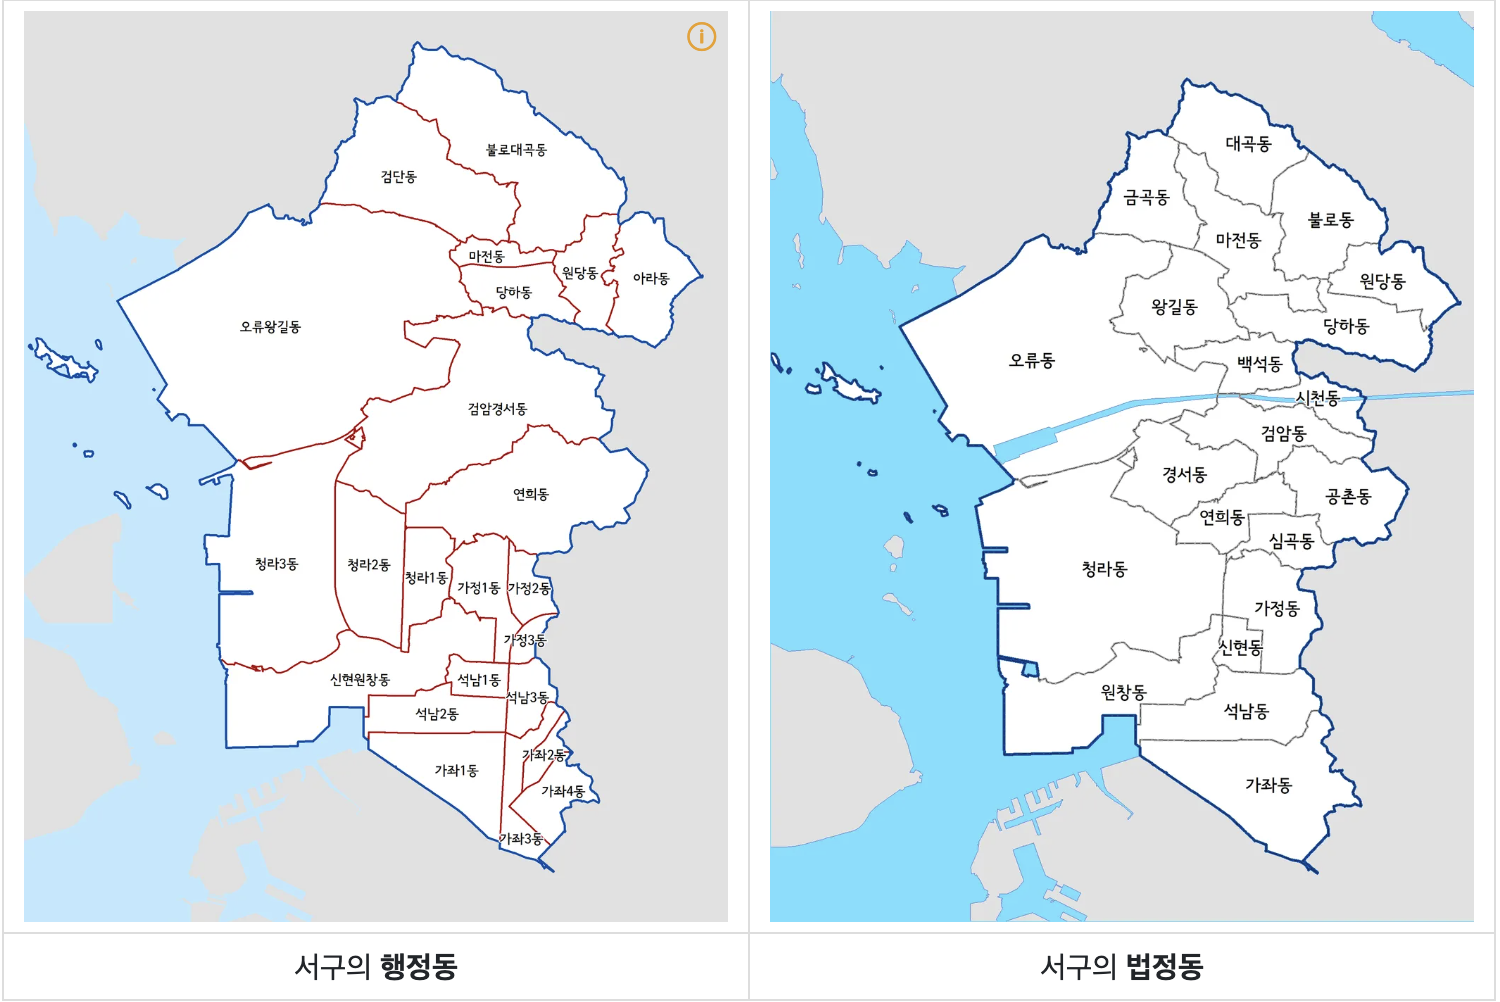

In [16]:
# "버스정류장 주소"와 "행정구역(법정동 기준)"이 가지고 있는 행정동 명에는 차이가 있다"
# "원찬동"은 "원창동"의 오타인 것으로" 보임, '행정동 명' 열에서 "원찬동"을 "원창동"으로 수정
# 인천 서구 행정동 → 법정동 매핑 테이블
# 위 이미지를 통한 매칭

manual_name_map = {
    '가정1동': '가정동',
    '가정2동': '가정동',
    '가정3동': '가정동',
    '가좌1동': '가좌동',
    '가좌2동': '가좌동',
    '가좌3동': '청라동',
    '가좌4동': '청라동',
    '검단1동': '검단동',
    '검단2동': '불로대곡동',
    '검단3동': '원당동',
    '검단4동': '당하동',
    '검단5동': '오류왕길동',
    '청라1동': '청라동',
    '청라2동': '청라동',
    '청라3동': '청라동',
    '석남1동': '석남동',
    '석남2동': '석남동',
    '석남3동': '석남동',
    '원찬동': '원창동',             # 오타 수정

    '송림4동': None               # 동구 소속 → 제외하거나 필터링
}

gdf_seogu_bus['행정동 명'] = gdf_seogu_bus['행정동 명'].replace(manual_name_map) # 변경 적용
gdf_seogu_bus = gdf_seogu_bus.rename(columns={'행정동 명': '법정동 명'}) # 컬럼 이름 변경
gdf_seogu_bus = gdf_seogu_bus.dropna(subset=['법정동 명'])  # None 제거 (예: 송림4동)

In [17]:
# 확인
# 이름 집합 생성
bus_dong_set = set(gdf_seogu_bus['법정동 명'].unique())
legal_dong_set = set(gdf_legal_dong['법정동 명'].unique())

# 각각 포함 여부에 따른 분류
only_bus_dong = bus_dong_set - legal_dong_set
only_legal_dong = legal_dong_set - bus_dong_set
in_both = bus_dong_set & legal_dong_set

# 최대 길이에 맞춰 정렬 및 채우기
max_len = max(len(only_bus_dong), len(only_legal_dong), len(in_both))
only_bus_dong = sorted(only_bus_dong) + [''] * (max_len - len(only_bus_dong))
only_legal_dong = sorted(only_legal_dong) + [''] * (max_len - len(only_legal_dong))
in_both = sorted(in_both) + [''] * (max_len - len(in_both))

# 비교용 DataFrame 생성
comparison_df = pd.DataFrame({
    '버스정류장 주소에만 있음': only_bus_dong,
    '행정구역(법정동 기준)에만 있음': only_legal_dong,
    '둘 다 있음': in_both
})

comparison_df

,버스정류장 주소에만 있음,행정구역(법정동 기준)에만 있음,둘 다 있음
0,검단동,공촌동,가정동
1,검암경서동,시천동,가좌동
2,불로대곡동,신현동,검암동
3,신현원창동,왕길동,경서동
4,아라동,,금곡동
5,오류왕길동,,당하동
6,,,대곡동
7,,,마전동
8,,,백석동
9,,,불로동


- 버스정류장 주소에만 있음 : 아직 법정동으로 변형이 안 된 것일 것
- 행정구역(법정동 기준)에만 있음 : 아직 버스가 없는 동 (전환이 덜 되었거나,  진짜 없는 곳)

# 6. 법정동 명으로 잘 변경 됐는 지 확인

In [18]:
# 이름 집합 생성
bus_dong_set = set(gdf_seogu_bus['법정동 명'].unique())
legal_dong_set = set(gdf_legal_dong['법정동 명'].unique())

# 각각 포함 여부에 따른 분류
only_bus_dong = bus_dong_set - legal_dong_set
only_legal_dong = legal_dong_set - bus_dong_set
in_both = bus_dong_set & legal_dong_set

only_bus_dong

{'검단동', '검암경서동', '불로대곡동', '신현원창동', '아라동', '오류왕길동'}

# 7. 6개의 동은 두 개 이상의 법정동을 포함하고 있으므로, 해당 동에 있는 버스정류장 필터링

In [19]:
# only_in_bus 리스트를 바탕으로 필터링
df_filtered = bus_seogu_df[bus_seogu_df['행정동 명'].isin(only_bus_dong)]

# 결과 확인
import pandas as pd
import IPython
IPython.display.display(df_filtered[['정류소 명', '행정동 명', '경도', '위도']])

,정류소 명,행정동 명,경도,위도
1,(주)경동세라믹스,오류왕길동,126.616978,37.559186
24,41번구종점,신현원창동,126.667195,37.513796
38,E편한세상,불로대곡동,126.693537,37.618146
40,E편한세상,불로대곡동,126.693527,37.618547
47,GS칼텍스,신현원창동,126.640315,37.506834
...,...,...,...,...
6726,호반써밋1차 3101동,아라동,126.707719,37.594338
6727,호반써밋1차 3101동,아라동,126.707935,37.593594
6745,홈씨씨인천점,신현원창동,126.646445,37.514626
6746,홈씨씨인천점,신현원창동,126.646300,37.514317


너무 많아서 직접 확인하여 수정 하기는 포기

In [20]:
print("버스 정류장 데이터 CRS:", gdf_seogu_bus.crs)
print("법정동 GeoJSON 데이터 CRS:", gdf_legal_dong.crs)

버스 정류장 데이터 CRS: EPSG:4326
법정동 GeoJSON 데이터 CRS: EPSG:4326


## 8. 법정동으로 변환

좌표 기반 수동 공간 조인 (fallback)
---
각 정류장의 위도·경도를 가지고, 다시 GeoJSON polygon 내부 포함 여부를 직접 확인하는 방식

In [21]:
def assign_legal_dong(df_bus, gdf_legal, lat_col='위도', lon_col='경도', fallback_manual=None):
    """
    df_bus: 정류장 데이터 (위경도 포함된 pandas or GeoDataFrame)
    gdf_legal: 법정동 Polygon GeoDataFrame ('법정동 명' 포함)
    fallback_manual: dict 형태의 수동 매핑 딕셔너리 (key: 정류소 명, value: 법정동 명) - 기본값은 None
    """

    # Step 1: Point 생성 및 GeoDataFrame 변환
    df_bus['geometry'] = df_bus.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)
    gdf_bus = gpd.GeoDataFrame(df_bus, geometry='geometry', crs='EPSG:4326')
    gdf_legal = gdf_legal.to_crs(gdf_bus.crs)

    # Step 2: contains 기반 매핑
    def find_dong_by_containment(point):
        for _, row in gdf_legal.iterrows():
            if row['geometry'].contains(point):
                return row['법정동 명']
        return None

    gdf_bus['법정동 명'] = gdf_bus['geometry'].apply(find_dong_by_containment)

    # Step 3: distance 기반 fallback (NaN만)
    def find_nearest_dong(point):
        distances = gdf_legal.geometry.distance(point)
        nearest_idx = distances.idxmin()
        return gdf_legal.loc[nearest_idx, '법정동 명']

    gdf_bus.loc[gdf_bus['법정동 명'].isna(), '법정동 명'] = gdf_bus.loc[
        gdf_bus['법정동 명'].isna(), 'geometry'
    ].apply(find_nearest_dong)

    # Step 4: 수동 매핑 (원할 때만 사용)
    if fallback_manual:
        gdf_bus['법정동 명'] = gdf_bus.apply(
            lambda row: fallback_manual.get(row['정류소 명'], row['법정동 명']),
            axis=1
        )
    return gdf_bus

In [22]:
gdf_seogu_bus_final = assign_legal_dong(
    df_bus=gdf_seogu_bus,
    gdf_legal=gdf_legal_dong,
    lat_col='위도',
    lon_col='경도'
)

<ipython-input-21-1136357824>:24: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf_legal.geometry.distance(point)


In [23]:
# 1. 이름 집합 생성
bus_dong_set = set(gdf_seogu_bus_final['법정동 명'].dropna().unique())
geojson_dong_set = set(gdf_legal_dong['법정동 명'].dropna().unique())

# 2. 차집합 및 교집합 계산
only_in_bus = bus_dong_set - geojson_dong_set
only_in_geojson = geojson_dong_set - bus_dong_set
in_both = bus_dong_set & geojson_dong_set

# 3. 정렬 및 길이 맞춰서 비교 테이블 만들기
max_len = max(len(only_in_bus), len(only_in_geojson), len(in_both))

only_in_bus = sorted(only_in_bus) + [''] * (max_len - len(only_in_bus))
only_in_geojson = sorted(only_in_geojson) + [''] * (max_len - len(only_in_geojson))
in_both = sorted(in_both) + [''] * (max_len - len(in_both))

# 4. 비교용 DataFrame 생성
comparison_df = pd.DataFrame({
    '버스정류장 데이터에만 있음': only_in_bus,
    'GeoJSON 데이터에만 있음': only_in_geojson,
    '둘 다 있음': in_both
})

comparison_df


,버스정류장 데이터에만 있음,GeoJSON 데이터에만 있음,둘 다 있음
0,,시천동,가정동
1,,,가좌동
2,,,검암동
3,,,경서동
4,,,공촌동
5,,,금곡동
6,,,당하동
7,,,대곡동
8,,,마전동
9,,,백석동


### 진짜 시천동엔 버스 정류장이 없는가?


> 시천동을 경유했던 최후의 버스 노선으로, 2021년 10월 15일까지 폐선된 597번의 시천동 구간 대체 노선으로 운행했다. 아라마루전망대~한들마을입구까지는 단독 구간으로, 대도시에서 볼 수 없는 한적한 시골 풍경을 볼 수 있었다. 하지만 2021년 개편으로 검단신도시 경유로 바뀌면서 더 이상 시천동에서 시내버스를 이용할 수 없게 되었다.

출처 : 인천 버스 87 (나무위키)
https://namu.wiki/w/%EC%9D%B8%EC%B2%9C%20%EB%B2%84%EC%8A%A4%2087




### 공간 매핑이 완료된 **버스 정류장 데이터 (gdf_seogu_bus_final)**를 CSV로 저장

In [24]:
# geometry 열은 CSV로 저장할 필요가 없으므로 제거
gdf_seogu_bus_final.drop(columns='geometry').to_csv('버스정류장_법정동매핑.csv', index=False)
# GeoDataFrame으로 바로 저장
gdf_seogu_bus_final.to_file("버스정류장_법정동매핑.geojson", driver="GeoJSON")
